# Inference example for 2D U-Net model trained on BraTS Dataset
In this tutorial, we will use the Intel® Distribution of OpenVINO™ Toolkit to perform inference. We will load a tensorflow model thats been frozen and we will convert it to the OpenVINO version of the model (IR) and perform inference on a few Intel® samples from the Medical Decathlon dataset.

This version of the tutorial is set to run on the Intel® Devcloud for the Edge development server and will run with version 2020.4 LTS or with 2021.4.

There is a version of this tutorial that runs on the edge hardware solutions including various CPU's, GPU's and VPU devices. If you browse to the Build section on the Devcloud home page and scroll down to the Brain Segmentation example you can see how to setup and submit a script file for this scenario.

### Inferencing with the Intel® Distribution of OpenVINO™ Toolkit
In order to use Intel® OpenVINO™ Toolkit, we need to do a few steps:

1. Import Python libraries.
1. Setup the configuration, for example dataset and image file paths
1. Define helper functions.
1. Use the OpenVINO Model Optimizer to convert the frozen model to the OpenVINO Intermediate Representation (IR) format
1. Load data and run inference, and calculate the accuracy
1. Display the original image, the ground truth, and the inference results, and save the combined images to a file.

### Step 1 Import Python* Libraries

In [1]:
# matrix math and operating system modules
import numpy as np
import os

# Sequence is a base object for fitting to a dataset, JSON is used to parse the dataset JSON file
from tensorflow.keras.utils import Sequence
import json
# OpenVINO Python library
from openvino.inference_engine import IECore

#Provides read +/- write access to some common medical and neuroimaging file formats, to read header and image data
import nibabel as nib
#pyplot module provides a MATLAB*-like interface
import matplotlib.pyplot as plt
#for measuring inference time
import time 



### Step 2 Configuration

In [2]:
saved_model_dir = "./output/2d_unet_decathlon"
IR_batch_size = 1
precision="FP32"
openvino_model_dir = os.path.join("output", precision)
openvino_model_name = "2d_unet_decathlon"
# if you try this at home, unzip the BraTS dataset into this directory
data_path = "./Task01_BrainTumor/"

crop_dim=128  # Original resolution (240)
#the following are not used for inference but are needed because we are using the same "training" function for getting inference images.
batch_size = 128
seed=816
train_test_split=0.85

# Create output directory for images
png_directory = "inference_examples"
if not os.path.exists(png_directory):
    os.makedirs(png_directory)

if not os.path.exists(saved_model_dir):
    print('File {} doesn\'t exist. Please make sure you have a trained TF model'.format(saved_model_dir))

print ("Configuration complete.")



Configuration complete.


### Step 3: Convert the Tensorflow* saved model to the Intermediate Representation (IR) with Intel® OpenVINO™
In this step, we will use the Intel® OpenVINO™'s `model optimizer` to convert the frozen TensorFlow* model to Intel® OpenVINO™ IR format.

Let's first set up a few environment variables for the bash code snippet to work. The code below will create a **FP32** precision model.  

In [3]:

!mo.py \
      --saved_model_dir $saved_model_dir \
      --batch $IR_batch_size \
      --data_type $precision \
      --output_dir $openvino_model_dir \
      --model_name $openvino_model_name


Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/home/u115517/Reference-samples/iot-devcloud/openvino-dev-latest/certification-program/English/brain-tumor-segmentation/output/FP32
	- IR output name: 	2d_unet_decathlon
	- Log level: 	ERROR
	- Batch: 	1
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers implementation: 	None
	- Update the configuration file with

If you would like to infer on a Neural Compute Stick, you will need to output a **FP16** precision model. To do this, you simply need to change the `--data_type` from FP32 to FP16:

```
!mo.py \
      --saved_model_dir $saved_model_dir \
      --batch $IR_batch_size \
      --data_type FP16  \
      --output_dir openvino_model_dir/FP16  \
      --model_name 2d_unet_decathlon
```

### Step 4: Define some functions
#### Step 4a: Define the DICE coefficient
As we have seen in the training tutorial, we define the Sorensen Dice score coefficient, to measure the overlap between the prediction and ground truth masks: Given two sets, X and Y, it is defined as

\begin{equation}
dice = \frac{2|X\cap Y|}{|X|+|Y|}
\end{equation}

In [4]:
def calc_dice(target, prediction, smooth=0.0001):
    """
    Sorensen Dice coefficient
    """
    print (np.sum(target))
    print (np.sum(prediction))
    print (batch_size)
    prediction = np.round(prediction)

    numerator = 2.0 * np.sum(target * prediction) + smooth
    denominator = np.sum(target) + np.sum(prediction) + smooth
    coef = numerator / denominator

    return coef

#### Step 4b: Define the get_decathlon_filelist() function and the DatasetGenerator() class

This function and class are copied directly from the training repo https://github.com/IntelAI/unet and contain extra functions that are not used for inference. Once defined they are run on the ./Task01_BrainTumor dataset
    
    

In [5]:
def get_decathlon_filelist(data_path, seed=816, split=0.85):
    """
    Get the paths for the original decathlon files
    """
    json_filename = os.path.join(data_path, "dataset.json")

    try:
        with open(json_filename, "r") as fp:
            experiment_data = json.load(fp)
    except IOError as e:
        raise Exception("File {} doesn't exist. It should be part of the "
              "Decathlon directory".format(json_filename))

    # Print information about the Decathlon experiment data
    print("*" * 30)
    print("=" * 30)
    print(data_path)
    print("Dataset name:        ", experiment_data["name"])
    print("Dataset description: ", experiment_data["description"])
    print("Tensor image size:   ", experiment_data["tensorImageSize"])
    print("Dataset release:     ", experiment_data["release"])
    print("Dataset reference:   ", experiment_data["reference"])
    print("Dataset license:     ", experiment_data["licence"])  # sic
    print("=" * 30)
    print("*" * 30)

    """
	Randomize the file list. Then separate into training and
	validation lists. We won't use the testing set since we
	don't have ground truth masks for this; instead we'll
	split the validation set into separate test and validation
	sets.
	"""
    # Set the random seed so that always get same random mix
    np.random.seed(seed)
    numFiles = experiment_data["numTraining"]
    idxList = np.arange(numFiles)  # List of file indices
    np.random.shuffle(idxList) # Shuffle the indices to randomize train/test/split
    
    trainIdx = int(np.floor(numFiles*split)) # index for the end of the training files
    trainList = idxList[:trainIdx]

    otherList = idxList[trainIdx:]
    numOther = len(otherList)
    otherIdx = numOther//2  # index for the end of the testing files
    validateList = otherList[:otherIdx]
    testList = otherList[otherIdx:]

    trainFiles = []
    for idx in trainList:
        trainFiles.append(os.path.join(data_path, experiment_data["training"][idx]["label"]))

    validateFiles = []
    for idx in validateList:
        validateFiles.append(os.path.join(data_path, experiment_data["training"][idx]["label"]))

    testFiles = []
    for idx in testList:
        testFiles.append(os.path.join(data_path, experiment_data["training"][idx]["label"]))

    print("Number of training files   = {}".format(len(trainList)))
    print("Number of validation files = {}".format(len(validateList)))
    print("Number of testing files    = {}".format(len(testList)))

    return trainFiles, validateFiles, testFiles
class DatasetGenerator(Sequence):
    """
    TensorFlow Dataset from Python/NumPy Iterator
    """
    
    def __init__(self, filenames, batch_size=8, crop_dim=[240,240], augment=False, seed=816):
        


        img = np.array(nib.load(filenames[0]).dataobj) # Load the first image
        self.slice_dim = 2  # We'll assume z-dimension (slice) is last
        # Determine the number of slices (we'll assume this is consistent for the other images)
        self.num_slices_per_scan = img.shape[self.slice_dim]  

        # If crop_dim == -1, then don't crop
        if crop_dim[0] == -1:
            crop_dim[0] = img.shape[0]
        if crop_dim[1] == -1:
            crop_dim[1] = img.shape[1]
        self.crop_dim = crop_dim  

        self.filenames = filenames
        self.batch_size = batch_size

        self.augment = augment
        self.seed = seed
        
        self.num_files = len(self.filenames)
        
        self.ds = self.get_dataset()

    def preprocess_img(self, img):
        """
        Preprocessing for the image
        z-score normalize
        """
        return (img - img.mean()) / img.std()

    def preprocess_label(self, label):
        """
        Predict whole tumor. If you want to predict tumor sections, then 
        just comment this out.
        """
        label[label > 0] = 1.0

        return label
    
    def augment_data(self, img, msk):
        """
        Data augmentation
        Flip image and mask. Rotate image and mask.
        """
        
        if np.random.rand() > 0.5:
            ax = np.random.choice([0,1])
            img = np.flip(img, ax)
            msk = np.flip(msk, ax)

        if np.random.rand() > 0.5:
            rot = np.random.choice([1, 2, 3])  # 90, 180, or 270 degrees

            img = np.rot90(img, rot, axes=[0,1])  # Rotate axes 0 and 1
            msk = np.rot90(msk, rot, axes=[0,1])  # Rotate axes 0 and 1

        return img, msk

    def crop_input(self, img, msk):
            """
            Randomly crop the image and mask
            """

            slices = []

            # Do we randomize?
            is_random = self.augment and np.random.rand() > 0.5

            for idx, idy in enumerate(range(2)):  # Go through each dimension

                cropLen = self.crop_dim[idx]
                imgLen = img.shape[idy]

                start = (imgLen-cropLen)//2

                ratio_crop = 0.20  # Crop up this this % of pixels for offset
                # Number of pixels to offset crop in this dimension
                offset = int(np.floor(start*ratio_crop))

                if offset > 0:
                    if is_random:
                        start += np.random.choice(range(-offset, offset))
                        if ((start + cropLen) > imgLen):  # Don't fall off the image
                            start = (imgLen-cropLen)//2
                else:
                    start = 0

                slices.append(slice(start, start+cropLen))

            return img[tuple(slices)], msk[tuple(slices)]

    def generate_batch_from_files(self):
        """
        Python generator which goes through a list of filenames to load.
        The files are 3D image (slice is dimension index 2 by default). However,
        we need to yield them as a batch of 2D slices. This generator
        keeps yielding a batch of 2D slices at a time until the 3D image is 
        complete and then moves to the next 3D image in the filenames.
        An optional `randomize_slices` allows the user to randomize the 3D image 
        slices after loading if desired.
        """
 
        np.random.seed(self.seed)  # Set a random seed

        idx = 0
        idy = 0

        while True:

            """
            Pack N_IMAGES files at a time to queue
            """
            NUM_QUEUED_IMAGES = 1 + self.batch_size // self.num_slices_per_scan  # Get enough for full batch + 1
            
            for idz in range(NUM_QUEUED_IMAGES):

                label_filename = self.filenames[idx]

                #img_filename   = label_filename.replace("_seg.nii.gz", "_flair.nii.gz") # BraTS 2018
                img_filename   = label_filename.replace("labelsTr", "imagesTr")  # Medical Decathlon
                
                img = np.array(nib.load(img_filename).dataobj)
                img = img[:,:,:,0]  # Just take FLAIR channel (channel 0)
                img = self.preprocess_img(img)

                label = np.array(nib.load(label_filename).dataobj)
                label = self.preprocess_label(label)
                
                # Crop input and label
                img, label = self.crop_input(img, label)

                if idz == 0:
                    img_stack = img
                    label_stack = label

                else:

                    img_stack = np.concatenate((img_stack,img), axis=self.slice_dim)
                    label_stack = np.concatenate((label_stack,label), axis=self.slice_dim)
                
                idx += 1 
                if idx >= len(self.filenames):
                    idx = 0
                    np.random.shuffle(self.filenames) # Shuffle the filenames for the next iteration
            
            img = img_stack
            label = label_stack

            num_slices = img.shape[self.slice_dim]
            
            if self.batch_size > num_slices:
                raise Exception("Batch size {} is greater than"
                                " the number of slices in the image {}."
                                " Data loader cannot be used.".format(self.batch_size, num_slices))

            """
            We can also randomize the slices so that no 2 runs will return the same slice order
            for a given file. This also helps get slices at the end that would be skipped
            if the number of slices is not the same as the batch order.
            """
            if self.augment:
                slice_idx = np.random.choice(range(num_slices), num_slices)
                img = img[:,:,slice_idx]  # Randomize the slices
                label = label[:,:,slice_idx]

            name = self.filenames[idx]
            
            if (idy + self.batch_size) < num_slices:  # We have enough slices for batch
                img_batch, label_batch = img[:,:,idy:idy+self.batch_size], label[:,:,idy:idy+self.batch_size]   

            else:  # We need to pad the batch with slices

                img_batch, label_batch = img[:,:,-self.batch_size:], label[:,:,-self.batch_size:]  # Get remaining slices

            if self.augment:
                img_batch, label_batch = self.augment_data(img_batch, label_batch)
                
            if len(np.shape(img_batch)) == 3:
                img_batch = np.expand_dims(img_batch, axis=-1)
            if len(np.shape(label_batch)) == 3:
                label_batch = np.expand_dims(label_batch, axis=-1)
                
            yield np.transpose(img_batch, [2,0,1,3]).astype(np.float32), np.transpose(label_batch, [2,0,1,3]).astype(np.float32)


            idy += self.batch_size
            if idy >= num_slices: # We finished this file, move to the next
                idy = 0
                idx += 1

            if idx >= len(self.filenames):
                idx = 0
                np.random.shuffle(self.filenames) # Shuffle the filenames for the next iteration
                

    def get_input_shape(self):
        """
        Get image shape
        """
        return [self.crop_dim[0], self.crop_dim[1], 1]
        
    def get_output_shape(self):
        """
        Get label shape
        """
        return [self.crop_dim[0], self.crop_dim[1], 1] 
    
    def get_dataset(self):
        """
        Return a dataset
        """
        ds = self.generate_batch_from_files()
        
        return ds  
    
    def __len__(self):
        return (self.num_slices_per_scan * self.num_files)//self.batch_size

    def __getitem__(self, idx):
        return next(self.ds)
        
    def plot_samples(self):
        """
        Plot some random samples
        """
         
        img, label = next(self.ds)
        
        print(img.shape)
 
        plt.figure(figsize=(10,10))
        
        slice_num = 3
        plt.subplot(2,2,1)
        plt.imshow(img[slice_num,:,:,0]);
        plt.title("MRI, Slice #{}".format(slice_num));

        plt.subplot(2,2,2)
        plt.imshow(label[slice_num,:,:,0]);
        plt.title("Tumor, Slice #{}".format(slice_num));

        slice_num = self.batch_size - 1
        plt.subplot(2,2,3)
        plt.imshow(img[slice_num,:,:,0]);
        plt.title("MRI, Slice #{}".format(slice_num));

        plt.subplot(2,2,4)
        plt.imshow(label[slice_num,:,:,0]);
        plt.title("Tumor, Slice #{}".format(slice_num));


trainFiles, validateFiles, testFiles = get_decathlon_filelist(data_path=data_path, seed=seed, split=train_test_split)

ds_test = DatasetGenerator(testFiles, 
                           batch_size=batch_size, 
                           crop_dim=[crop_dim, crop_dim], 
                           augment=False, 
                           seed=seed)


******************************
./Task01_BrainTumor/
Dataset name:         BRATS
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    4D
Dataset release:      2.0 04/05/2018
Dataset reference:    https://www.med.upenn.edu/sbia/brats2017.html
Dataset license:      CC-BY-SA 4.0
******************************
Number of training files   = 411
Number of validation files = 36
Number of testing files    = 37


#### Step 4c: Define the plot_results() function

In [6]:
%matplotlib inline

def plot_results(ds):
    
    img, msk = next(ds.ds)

    idx = np.argmax(np.sum(np.sum(msk[:,:,:,0], axis=1), axis=1)) # find the slice with the largest tumor
  
    plt.figure(figsize=(10,10))

    plt.subplot(1, 3, 1)
    plt.imshow(img[idx, :, :, 0], cmap="bone", origin="lower")
    plt.title("MRI {}".format(idx), fontsize=20)

    plt.subplot(1, 3, 2)
    plt.imshow(msk[idx, :, :], cmap="bone", origin="lower")
    plt.title("Ground truth", fontsize=20)

    plt.subplot(1, 3, 3)

    # Predict using the OpenVINO model
    # NOTE: OpenVINO expects channels first for input and output
    # So we transpose the input and output
    start_time = time.time()
    res = exec_net.infer({input_layer_name: np.transpose(img[[idx]], [0,3,1,2])})
 
    prediction = np.transpose(res[output_layer_name], [0,2,3,1])
  
    print("Elapsed time = {:.4f} msecs".format(1000.0*(time.time()-start_time)))

    plt.imshow(prediction[0,:,:,0], cmap="copper", origin="lower")
    plt.title("Prediction\nDice = {:.4f}".format(calc_dice(msk[idx, :, :], prediction)), fontsize=20)
    save_name = os.path.join(png_directory, "prediction_openvino_{}.png".format( idx))
    print("Saved as: {}".format(save_name))
    plt.savefig(save_name)
    

### Step 5: Setup Inferencing with Intel® OpenVINO™
Initialize the IECore() function, read the networks XML and BIN files.

Get the input and output layer names.

Define the device used for inference and load the plugin.

In [7]:
print ("OpenVINO Model Directory = ",openvino_model_dir)
print ("OpenVINO Model Name = ",openvino_model_name)
path_to_xml_file = "{}.xml".format(os.path.join(openvino_model_dir, openvino_model_name))
path_to_bin_file = "{}.bin".format(os.path.join(openvino_model_dir, openvino_model_name))
print("OpenVINO IR: {}, {}".format(path_to_xml_file, path_to_bin_file))

ie = IECore()
net = ie.read_network(model=path_to_xml_file, weights=path_to_bin_file)

input_layer_name = next(iter(net.input_info))
output_layer_name = next(iter(net.outputs))
print("Input layer name = {}\nOutput layer name = {}".format(input_layer_name, output_layer_name))

exec_net = ie.load_network(network=net, device_name="CPU", num_requests=1)

OpenVINO Model Directory =  output/FP32
OpenVINO Model Name =  2d_unet_decathlon
OpenVINO IR: output/FP32/2d_unet_decathlon.xml, output/FP32/2d_unet_decathlon.bin
Input layer name = mrimages
Output layer name = StatefulPartitionedCall/2DUNet_Brats_Decathlon/PredictionMask/Sigmoid


### Step 6 Run the inference on a set of images 
Plot the originals, the ground truth, and the predictions with Matplotlib and save to PNG files

Elapsed time = 15.6653 msecs
2687.0
1552.0374
128
Saved as: inference_examples/prediction_openvino_72.png


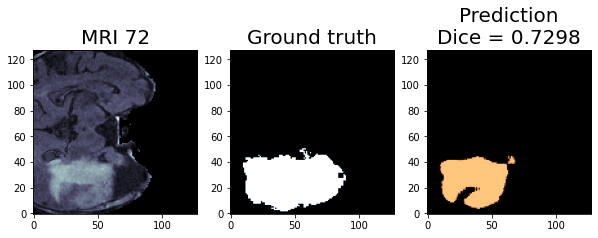

In [8]:
plot_results(ds_test)



Elapsed time = 10.8941 msecs
3813.0
1920.777
128
Saved as: inference_examples/prediction_openvino_36.png


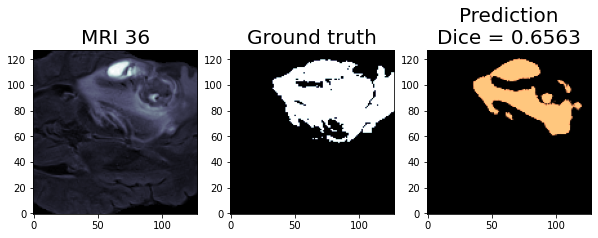

In [9]:
plot_results(ds_test)

Elapsed time = 11.9812 msecs
3462.0
119.42017
128
Saved as: inference_examples/prediction_openvino_92.png


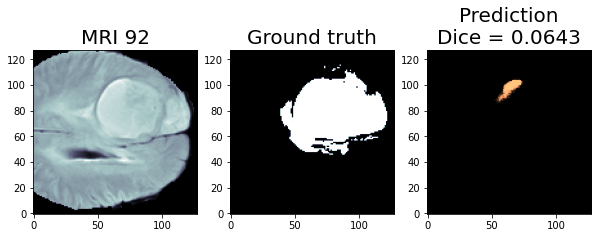

In [10]:
plot_results(ds_test)

Elapsed time = 10.8140 msecs
3299.0
1551.9326
128
Saved as: inference_examples/prediction_openvino_67.png


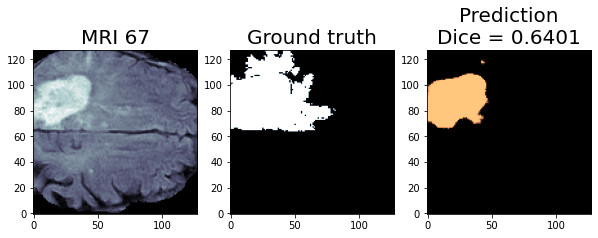

In [11]:
plot_results(ds_test)

Elapsed time = 10.4721 msecs
1472.0
1319.2498
128
Saved as: inference_examples/prediction_openvino_88.png


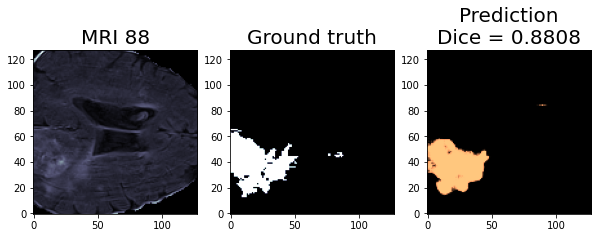

In [12]:
plot_results(ds_test)

Elapsed time = 10.9267 msecs
2447.0
2353.775
128
Saved as: inference_examples/prediction_openvino_42.png


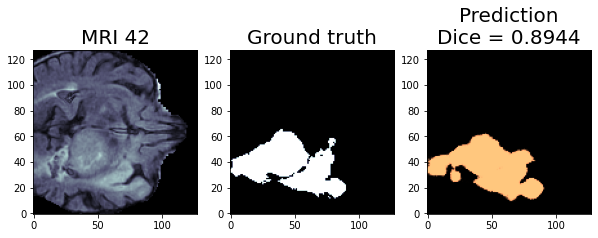

In [13]:
plot_results(ds_test)

Elapsed time = 13.8831 msecs
841.0
1003.9407
128
Saved as: inference_examples/prediction_openvino_104.png


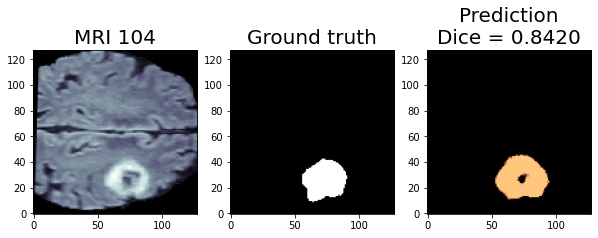

In [14]:
plot_results(ds_test)

# To receive credit please run the cell below

In [15]:
job_id = !qsub EAICertv1.0-Completed-Brain-Segmentation.sh -l nodes=1:idc001skl
print(job_id[0])
!/bin/echo "##" $(whoami) is running Edge_Certification Module4 -- Completed-Healthcare-Brain-Tumor–Image-Segmentation sample - 1 of 1

296857.v-qsvr-1.devcloud-edge
## u115517 is running Edge_Certification Module4 -- Completed-Healthcare-Brain-Tumor–Image-Segmentation sample - 1 of 1


## Next steps

- [More Jupyter Notebook Tutorials](https://www.intel.com/content/www/us/en/developer/tools/devcloud/edge/learn/tutorials.html?s=Newest) - additional sample application Jupyter* Notebook tutorials
- [Jupyter* Notebook Samples](https://www.intel.com/content/www/us/en/developer/tools/devcloud/edge/build/sample-apps.html?s=Newest) - sample applications
- [Intel® Distribution of OpenVINO™ toolkit Main Page](https://software.intel.com/openvino-toolkit) - learn more about the tools and use of the Intel® Distribution of OpenVINO™ toolkit for implementing inference on the edge

*Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. SPDX-License-Identifier: EPL-2.0*

*Copyright (c) 2019-2020 Intel Corporation*